In [3]:
#Install Package untuk Analisis HRV dan Deteksi EKG
!pip install wfdb
!pip install hrv-analysis
!pip install py-ecg-detectors
!pip install neurokit2
#Import Library
import pprint
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wfdb
import hrvanalysis
import ecgdetectors
import hrv
import neurokit2 as nk
from IPython.display import clear_output
from google.colab import output
from hrvanalysis import get_time_domain_features, remove_outliers, interpolate_nan_values

ModuleNotFoundError: No module named 'google.colab'

## MIT-BIH Normal Sinus Rhythm Database

https://physionet.org/content/nsrdb/1.0.0/

In [8]:
#!wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/ -P "C:/Users/ASUS/Documents/mit-bih-normal-sinus-rhythm-database-1.0.0"

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
#Membaca dan menyimpan direktori penyimpanan database NSRDB
NSRDB_DIR = "C:/Users/ASUS/Documents/mit-bih-normal-sinus-rhythm-database-1.0.0"

In [3]:
# Membaca anotasi dari rekaman EKG pasien 16265 database NSR2DB
record_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, "16265"))
record_obj.__dict__

{'record_name': '16265',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 11730944,
 'base_time': datetime.time(8, 4),
 'base_date': None,
 'comments': ['32 M'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.165, -0.325],
        [-0.155, -0.325],
        [-0.195, -0.305],
        ...,
        [-0.05 , -0.095],
        [-0.05 , -0.085],
        [-0.05 , -0.085]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['16265.dat', '16265.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-33, -65],
 'checksum': [15756, -21174],
 'block_size': [0, 0]}

start        : 0
end          : 1250
len(signal)  : 1250
seconds      : 5
len(r_peaks) : 15


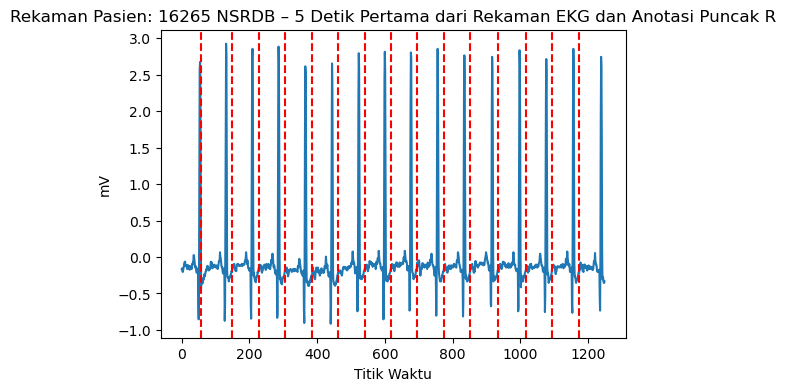

In [18]:
# Mengambil sebagian sinyal (slice) dari rekaman EKG dalam rentang waktu tertentu, dimulai dari 0 hingga 5 detik
def slice_signal(record_obj, start_sec=0, end_sec=5, fs=250, _print=True):
    start = fs * start_sec
    end = fs * end_sec
    signal = record_obj.p_signal[start:end, 0]

    if _print:
        print("start        :", start)
        print("end          :", end)
        print("len(signal)  :", len(signal))
        print("seconds      :", end_sec - start_sec)

    detectors = ecgdetectors.Detectors(fs)
    r_peaks = detectors.two_average_detector(signal)
    if _print:
        print("len(r_peaks) :", len(r_peaks))
    return signal, r_peaks

# Menghasilkan plot dari sinyal EKG dengan sumbu x menunjukkan titik waktu dan sumbu y menunjukkan amplitudo sinyal
def plot_signal(signal: np.array, r_peaks: list = None, figsize=(6, 4)):
    fig = plt.figure(figsize=figsize)
    plt.plot(signal)
    plt.title(f"Rekaman Pasien: 16265 NSRDB – 5 Detik Pertama dari Rekaman EKG dan Anotasi Puncak R")
    plt.xlabel("Titik Waktu")
    plt.ylabel("mV")

    if r_peaks:
        for xc in r_peaks:
            plt.axvline(x=xc, color='red', linestyle='--')
    plt.show()
signal, r_peaks = slice_signal(record_obj, start_sec=0, end_sec=5)
plot_signal(signal, r_peaks)

# OTHER CODE

In [53]:
ann = wfdb.rdann(os.path.join(NSRDB_DIR, "17453"), extension='atr')
r_peaks = np.array(ann.sample, dtype=int)
r_peaks[900:950]

array([85214, 85319, 85432, 85536, 85632, 85729, 85829, 85939, 86036,
       86128, 86216, 86300, 86391, 86487, 86594, 86692, 86798, 86909,
       87019, 87134, 87260, 87380, 87493, 87624, 87755, 87872, 88011,
       88140, 88258, 88386, 88501, 88618, 88758, 88894, 89014, 89146,
       89281, 89396, 89515, 89625, 89724, 89822, 89930, 90026, 90126,
       90230, 90327, 90440, 90553, 90662])

In [54]:
r_peaks.shape

(101173,)

In [20]:
import os
import wfdb
import pandas as pd

record_files = [file for file in os.listdir(NSRDB_DIR) if file.endswith(".atr")]

r_peak_data = []

for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]
    record_path = os.path.join(NSRDB_DIR, record_name)
    
    ann = wfdb.rdann(record_path, extension='atr')
    r_peaks = ann.sample
    
    r_peak_data.append({"RecordName": record_name, "RPeaks": r_peaks})

# Membuat dataframe dari list data
df = pd.DataFrame(r_peak_data)

# Menampilkan dataframe
df

,RecordName,RPeaks
0,16265,"[1, 52, 129, 207, 284, 364, 442, 522, 598, 675..."
1,16272,"[1, 73, 199, 321, 445, 567, 690, 815, 941, 106..."
2,16273,"[9, 87, 164, 241, 319, 397, 476, 557, 641, 723..."
3,16420,"[68, 148, 228, 309, 391, 474, 557, 643, 727, 8..."
4,16483,"[18, 99, 178, 257, 337, 417, 497, 577, 657, 73..."
5,16539,"[72, 168, 268, 364, 454, 543, 636, 746, 866, 9..."
6,16773,"[1, 50, 90, 156, 196, 263, 303, 364, 403, 466,..."
7,16786,"[16, 87, 195, 305, 408, 515, 627, 734, 837, 94..."
8,16795,"[11, 58, 118, 164, 230, 276, 344, 390, 468, 51..."
9,17052,"[35, 150, 264, 374, 485, 601, 714, 831, 948, 1..."


In [21]:
# Tambahkan kolom "Jumlah_RPeaks"
df['Jumlah_RPeaks'] = df['RPeaks'].apply(len)

# Tampilkan DataFrame
df

,RecordName,RPeaks,Jumlah_RPeaks
0,16265,"[1, 52, 129, 207, 284, 364, 442, 522, 598, 675...",100955
1,16272,"[1, 73, 199, 321, 445, 567, 690, 815, 941, 106...",97146
2,16273,"[9, 87, 164, 241, 319, 397, 476, 557, 641, 723...",90097
3,16420,"[68, 148, 228, 309, 391, 474, 557, 643, 727, 8...",102436
4,16483,"[18, 99, 178, 257, 337, 417, 497, 577, 657, 73...",104561
5,16539,"[72, 168, 268, 364, 454, 543, 636, 746, 866, 9...",108674
6,16773,"[1, 50, 90, 156, 196, 263, 303, 364, 403, 466,...",112897
7,16786,"[16, 87, 195, 305, 408, 515, 627, 734, 837, 94...",101739
8,16795,"[11, 58, 118, 164, 230, 276, 344, 390, 468, 51...",87678
9,17052,"[35, 150, 264, 374, 485, 601, 714, 831, 948, 1...",88002


In [28]:
ann = wfdb.rdann(os.path.join(NSRDB_DIR, "16773"), extension='atr')
annotation = np.array(ann.symbol)
annotation

array(['|', 'N', '|', ..., 'N', '|', '|'], dtype='<U1')

In [35]:
# Mendapatkan daftar file rekaman dalam direktori
record_files = [file for file in os.listdir(NSRDB_DIR) if file.endswith(".atr")]

# Membuat list untuk menyimpan hasil pemeriksaan
results = []

# Loop melalui setiap rekaman dan memeriksa nilai "N" pada index pertama
for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]  # Menghapus ekstensi ".ecg"
    record_path = os.path.join(NSRDB_DIR, record_name)
    
    # Membaca annotation
    ann = wfdb.rdann(record_path, extension='atr')
    
    # Memeriksa apakah nilai pertama dalam annotation adalah "N"
    first_symbol = ann.symbol[1000]
    
    results.append({"Rekaman": record_name, "Hasil Pemeriksaan": first_symbol == "N"})

# Membuat dataframe dari hasil pemeriksaan
dfy = pd.DataFrame(results)

# Menampilkan dataframe
dfy

,Rekaman,Hasil Pemeriksaan
0,16265,True
1,16272,True
2,16273,True
3,16420,True
4,16483,True
5,16539,True
6,16773,True
7,16786,True
8,16795,False
9,17052,True


In [43]:
import os
import numpy as np
import wfdb
import pandas as pd

# Mendefinisikan list untuk menyimpan hasil analisis
results = []

# Mendapatkan daftar file rekaman dalam direktori
record_files = [file for file in os.listdir(NSRDB_DIR) if file.endswith(".atr")]

# Loop melalui setiap rekaman dan memeriksa apakah ada nilai hilang
for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]
    record_path = os.path.join(NSRDB_DIR, record_name)
    
    # Membaca nilai r_peaks dari rekaman
    ann = wfdb.rdann(record_path, extension='atr')
    r_peaks = np.array(ann.sample, dtype=np.integer)
    
    # Memeriksa apakah ada nilai hilang (NaN) dalam r_peaks
    if np.isnan(r_peaks).any():
        result = {"Rekaman": record_name, "Status": "Ada nilai hilang (NaN)"}
    else:
        result = {"Rekaman": record_name, "Status": "Tidak ada nilai hilang (NaN)"}
    
    results.append(result)

# Membuat dataframe dari hasil analisis
df = pd.DataFrame(results)

# Menampilkan dataframe
df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_900\2831651460.py:19: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  r_peaks = np.array(ann.sample, dtype=np.integer)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_900\2831651460.py:19: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  r_peaks = np.array(ann.sample, dtype=np.integer)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_900\2831651460.py:19: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is 

,Rekaman,Status
0,16265,Tidak ada nilai hilang (NaN)
1,16272,Tidak ada nilai hilang (NaN)
2,16273,Tidak ada nilai hilang (NaN)
3,16420,Tidak ada nilai hilang (NaN)
4,16483,Tidak ada nilai hilang (NaN)
5,16539,Tidak ada nilai hilang (NaN)
6,16773,Tidak ada nilai hilang (NaN)
7,16786,Tidak ada nilai hilang (NaN)
8,16795,Tidak ada nilai hilang (NaN)
9,17052,Tidak ada nilai hilang (NaN)


In [9]:
# Mendapatkan daftar file rekaman dalam direktori
record_files = [file for file in os.listdir(NSRDB_DIR) if file.endswith(".atr")]

# Membuat list untuk menyimpan hasil pemeriksaan
results = []

# Loop melalui setiap rekaman dan memeriksa nilai "N" pada setiap annotation
for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]  # Menghapus ekstensi ".ecg"
    record_path = os.path.join(NSRDB_DIR, record_name)
    
    # Membaca annotation
    ann = wfdb.rdann(record_path, extension='atr')
    
    # Memeriksa apakah ada nilai yang tidak sama dengan "N"
    non_N_symbols = [symbol for symbol in ann.symbol if symbol != "N"]
    
    # Memeriksa apakah keterangan mengandung "ectopic beat"
    annotation_text = ann.aux_note[0].lower()  # Mengonversi ke huruf kecil untuk pencocokan yang tidak peka huruf besar/kecil
    has_ectopic_beat = "ectopic beat" in annotation_text
    
    # Menghitung jumlah ann.symbol yang tidak sama dengan "N"
    count_non_N = len(non_N_symbols)
    
    # Menyusun keterangan berdasarkan hasil pemeriksaan
    if count_non_N > 0:
        keterangan = "Terdapat Ectopic Beat"
    else:
        keterangan = "Tidak Ada Ectopic Beat"
    
    results.append({"Rekaman": record_name, "Hasil Pemeriksaan": keterangan, "Jumlah Ectopic Beat": count_non_N})

# Membuat dataframe dari hasil pemeriksaan
dfy = pd.DataFrame(results)

# Menampilkan dataframe
dfy

,Rekaman,Hasil Pemeriksaan,Jumlah Ectopic Beat
0,16265,Terdapat Ectopic Beat,739
1,16272,Terdapat Ectopic Beat,9389
2,16273,Terdapat Ectopic Beat,257
3,16420,Terdapat Ectopic Beat,375
4,16483,Terdapat Ectopic Beat,231
5,16539,Terdapat Ectopic Beat,409
6,16773,Terdapat Ectopic Beat,30935
7,16786,Terdapat Ectopic Beat,134
8,16795,Terdapat Ectopic Beat,806
9,17052,Terdapat Ectopic Beat,648


In [10]:
import numpy as np

# Mendapatkan daftar file rekaman dalam direktori
record_files = [file for file in os.listdir(NSRDB_DIR) if file.endswith(".atr")]

# Membuat list untuk menyimpan hasil pemeriksaan
results = []

# Loop melalui setiap rekaman dan memeriksa nilai "N" pada setiap annotation
for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]  # Menghapus ekstensi ".ecg"
    record_path = os.path.join(NSRDB_DIR, record_name)
    
    # Membaca annotation
    ann = wfdb.rdann(record_path, extension='atr')
    
    # Memeriksa apakah ada nilai yang tidak sama dengan "N"
    non_N_symbols = [symbol for symbol in ann.symbol if symbol != "N"]
    
    # Menghitung jumlah ann.symbol yang tidak sama dengan "N"
    count_non_N = len(non_N_symbols)
    
    # Menghitung jumlah r-peak
    r_peak = np.array(ann.sample, dtype=int)
    count_r_peak = len(r_peak)
    
    # Menghitung rasio Jumlah Symbol != 'N' / Jumlah r-peak
    if count_r_peak > 0:
        ratio = count_non_N / count_r_peak
    else:
        ratio = 0
    
    # Memeriksa apakah keterangan mengandung "ectopic beat"
    annotation_text = ann.aux_note[0].lower()  # Mengonversi ke huruf kecil untuk pencocokan yang tidak peka huruf besar/kecil
    has_ectopic_beat = "ectopic beat" in annotation_text
    
    # Menyusun keterangan berdasarkan hasil pemeriksaan
    if count_non_N > 0:
        keterangan = "Terdapat Ectopic Beat"
    else:
        keterangan = "Tidak Ada Ectopic Beat"
    
    results.append({"Rekaman": record_name, "Hasil Pemeriksaan": keterangan, "Jumlah Symbol != 'N'": count_non_N, "Jumlah r-peak": count_r_peak, "Rasio Symbol != 'N' / r-peak": ratio})

# Membuat dataframe dari hasil pemeriksaan
dfz = pd.DataFrame(results)

# Menampilkan dataframe
dfz

,Rekaman,Hasil Pemeriksaan,Jumlah Symbol != 'N',Jumlah r-peak,Rasio Symbol != 'N' / r-peak
0,16265,Terdapat Ectopic Beat,739,100955,0.007320
1,16272,Terdapat Ectopic Beat,9389,97146,0.096648
2,16273,Terdapat Ectopic Beat,257,90097,0.002852
3,16420,Terdapat Ectopic Beat,375,102436,0.003661
4,16483,Terdapat Ectopic Beat,231,104561,0.002209
5,16539,Terdapat Ectopic Beat,409,108674,0.003764
6,16773,Terdapat Ectopic Beat,30935,112897,0.274011
7,16786,Terdapat Ectopic Beat,134,101739,0.001317
8,16795,Terdapat Ectopic Beat,806,87678,0.009193
9,17052,Terdapat Ectopic Beat,648,88002,0.007363


In [8]:
#dfz.to_excel('pemeriksaan_ectopic_beat_nsrdb.xlsx')

In [12]:
import numpy as np

# Mendapatkan daftar file rekaman dalam direktori
record_files = [file for file in os.listdir(NSRDB_DIR) if file.endswith(".atr")]

# Membuat list untuk menyimpan hasil pemeriksaan
results = []

# Loop melalui setiap rekaman dan memeriksa nilai "N" pada setiap annotation
for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]  # Menghapus ekstensi ".ecg"
    record_path = os.path.join(NSRDB_DIR, record_name)
    
    # Membaca annotation
    ann = wfdb.rdann(record_path, extension='atr')
    
    # Menghitung jumlah outlier (RR interval < 300 atau RR interval > 2000)
    r_peak = np.array(ann.sample, dtype=int)
    FS = 128
    rr_intervals = [0] + list((r_peak[1:] - r_peak[:-1]) * 1000 / FS)
    count_outliers = np.sum((np.array(rr_intervals) < 300) | (np.array(rr_intervals) > 2000))
    
    # Memeriksa apakah ada nilai yang tidak sama dengan "N"
    non_N_symbols = [symbol for symbol in ann.symbol if symbol != "N"]
    
    # Menghitung jumlah ann.symbol yang tidak sama dengan "N"
    count_non_N = len(non_N_symbols)
    
    # Menghitung jumlah r-peak
    count_r_peak = len(r_peak)
    
    # Menghitung rasio Jumlah Symbol != 'N' / Jumlah r-peak
    if count_r_peak > 0:
        ratio = count_non_N / count_r_peak
    else:
        ratio = 0
    
    # Memeriksa apakah keterangan mengandung "ectopic beat"
    annotation_text = ann.aux_note[0].lower()  # Mengonversi ke huruf kecil untuk pencocokan yang tidak peka huruf besar/kecil
    has_ectopic_beat = "ectopic beat" in annotation_text
    
    # Menyusun keterangan berdasarkan hasil pemeriksaan
    if count_non_N > 0:
        keterangan = "Terdapat Ectopic Beat"
    else:
        keterangan = "Tidak Ada Ectopic Beat"
    
    results.append({"Rekaman": record_name, "Hasil Pemeriksaan": keterangan, "Jumlah Symbol != 'N'": count_non_N, "Jumlah r-peak": count_r_peak, "Rasio Symbol != 'N' / r-peak": ratio, "Jumlah Outliers RR Interval": count_outliers})

# Membuat dataframe dari hasil pemeriksaan
dfk = pd.DataFrame(results)

# Menampilkan dataframe
dfk

,Rekaman,Hasil Pemeriksaan,Jumlah Symbol != 'N',Jumlah r-peak,Rasio Symbol != 'N' / r-peak,Jumlah Outliers RR Interval
0,16265,Terdapat Ectopic Beat,739,100955,0.007320,456
1,16272,Terdapat Ectopic Beat,9389,97146,0.096648,3448
2,16273,Terdapat Ectopic Beat,257,90097,0.002852,240
3,16420,Terdapat Ectopic Beat,375,102436,0.003661,342
4,16483,Terdapat Ectopic Beat,231,104561,0.002209,209
5,16539,Terdapat Ectopic Beat,409,108674,0.003764,375
6,16773,Terdapat Ectopic Beat,30935,112897,0.274011,480
7,16786,Terdapat Ectopic Beat,134,101739,0.001317,81
8,16795,Terdapat Ectopic Beat,806,87678,0.009193,221
9,17052,Terdapat Ectopic Beat,648,88002,0.007363,351


In [13]:
import numpy as np

# Mendapatkan daftar file rekaman dalam direktori
record_files = [file for file in os.listdir(NSRDB_DIR) if file.endswith(".atr")]

# Membuat list untuk menyimpan hasil pemeriksaan
results = []

# Loop melalui setiap rekaman dan memeriksa nilai "N" pada setiap annotation
for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]  # Menghapus ekstensi ".ecg"
    record_path = os.path.join(NSRDB_DIR, record_name)
    
    # Membaca annotation
    ann = wfdb.rdann(record_path, extension='atr')
    
    # Menghitung jumlah outlier (RR interval < 300 atau RR interval > 2000)
    r_peak = np.array(ann.sample, dtype=int)
    FS = 128
    rr_intervals = [0] + list((r_peak[1:] - r_peak[:-1]) * 1000 / FS)
    count_outliers = np.sum((np.array(rr_intervals) < 300) | (np.array(rr_intervals) > 2000))
    
    # Menghitung jumlah RR interval dari masing-masing file
    total_rr_interval = np.sum(rr_intervals)
    
        
    # Menghitung jumlah r-peak
    count_r_peak = len(r_peak)
    
    # Menghitung rasio Jumlah Symbol != 'N' / Jumlah r-peak
    if count_r_peak > 0:
        ratio = count_non_N / count_r_peak
    else:
        ratio = 0
    
    # Menghitung rasio Jumlah Outliers RR Interval / Jumlah RR Interval Total
    if total_rr_interval > 0:
        ratio_outliers = count_outliers / total_rr_interval
    else:
        ratio_outliers = 0
    
    # Memeriksa apakah ada nilai yang tidak sama dengan "N"
    non_N_symbols = [symbol for symbol in ann.symbol if symbol != "N"]
    
    # Menghitung jumlah ann.symbol yang tidak sama dengan "N"
    count_non_N = len(non_N_symbols)
    
    # Memeriksa apakah keterangan mengandung "ectopic beat"
    annotation_text = ann.aux_note[0].lower()  # Mengonversi ke huruf kecil untuk pencocokan yang tidak peka huruf besar/kecil
    has_ectopic_beat = "ectopic beat" in annotation_text
    
    # Menyusun keterangan berdasarkan hasil pemeriksaan
    if count_non_N > 0:
        keterangan = "Terdapat Ectopic Beat"
    else:
        keterangan = "Tidak Ada Ectopic Beat"
    
    results.append({"Rekaman": record_name, "Hasil Pemeriksaan": keterangan, "Jumlah Symbol != 'N'": count_non_N, "Jumlah r-peak": count_r_peak, "Rasio Symbol != 'N' / r-peak": ratio, "Jumlah Outliers RR Interval": count_outliers, "Jumlah RR Interval Total": total_rr_interval, "Rasio Outliers RR Interval / RR Interval Total": ratio_outliers})

# Membuat dataframe dari hasil pemeriksaan
dfk = pd.DataFrame(results)

# Menampilkan dataframe
dfk

,Rekaman,Hasil Pemeriksaan,Jumlah Symbol != 'N',Jumlah r-peak,Rasio Symbol != 'N' / r-peak,Jumlah Outliers RR Interval,Jumlah RR Interval Total,Rasio Outliers RR Interval / RR Interval Total
0,16265,Terdapat Ectopic Beat,739,100955,0.019157,456,8.006199e+07,5.695586e-06
1,16272,Terdapat Ectopic Beat,9389,97146,0.007607,3448,8.439669e+07,4.085468e-05
2,16273,Terdapat Ectopic Beat,257,90097,0.104210,240,7.434914e+07,3.228013e-06
3,16420,Terdapat Ectopic Beat,375,102436,0.002509,342,7.776127e+07,4.398077e-06
4,16483,Terdapat Ectopic Beat,231,104561,0.003586,209,7.609923e+07,2.746414e-06
5,16539,Terdapat Ectopic Beat,409,108674,0.002126,375,8.466947e+07,4.428987e-06
6,16773,Terdapat Ectopic Beat,30935,112897,0.003623,480,7.814219e+07,6.142649e-06
7,16786,Terdapat Ectopic Beat,134,101739,0.304062,81,8.405174e+07,9.636921e-07
8,16795,Terdapat Ectopic Beat,806,87678,0.001528,221,7.474719e+07,2.956633e-06
9,17052,Terdapat Ectopic Beat,648,88002,0.009159,351,7.640027e+07,4.594225e-06


In [9]:
dfk.to_excel('NSRDB_RPeak_RRInterval_perFile.xlsx')

In [4]:
import numpy as np

# Mendefinisikan nama rekaman yang ingin Anda periksa
target_record = "16265"

# Mendapatkan daftar file rekaman dalam direktori
record_files = [file for file in os.listdir(NSRDB_DIR) if file.endswith(".atr")]

# Membuat list untuk menyimpan hasil pemeriksaan
results = []

# Loop melalui setiap rekaman
for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]  # Menghapus ekstensi ".ecg"
    
    if record_name == target_record:
        record_path = os.path.join(NSRDB_DIR, record_name)
        
        # Membaca annotation
        ann = wfdb.rdann(record_path, extension='atr')
        
        # Memeriksa apakah ann.symbol tidak sama dengan "N"
        non_N_indices = [i for i, symbol in enumerate(ann.symbol) if symbol != "N"]
        
        # Mengambil nilai puncak R yang sesuai dengan indeks non-N
        r_peak = np.array(ann.sample, dtype=int)
        r_peak_non_N = r_peak[non_N_indices]
        
        results = {"Rekaman": record_name, "R-Peak Non-N": r_peak_non_N}

# Membuat dataframe dari hasil pemeriksaan
df_r_peak = pd.DataFrame(results)

# Menampilkan dataframe
df_r_peak

,Rekaman,R-Peak Non-N
0,16265,1
1,16265,38144
2,16265,38688
3,16265,40104
4,16265,40768
...,...,...
734,16265,10240034
735,16265,10240125
736,16265,10240215
737,16265,10240256


In [14]:
# Mendapatkan puncak R (r-peak) dan annotation symbol untuk rekaman "16265"
record_name = "16265"

# Mencari indeks rekaman "16265" dalam dataframe hasil pemeriksaan
idx = dfk[dfk["Rekaman"] == record_name].index[0]

# Mendapatkan jumlah r-peak untuk rekaman "16265"
r_peak_16265 = np.array(wfdb.rdann(os.path.join(NSRDB_DIR, record_name), extension='atr').sample, dtype=int)

# Membaca annotation symbol untuk rekaman "16265"
record_path = os.path.join(NSRDB_DIR, record_name)
ann_16265 = wfdb.rdann(record_path, extension='atr')
ann_symbols_16265 = ann_16265.symbol

# Membuat dataframe berisi puncak R (r-peak) dan annotation symbol
df_16265 = pd.DataFrame({"Puncak R": r_peak_16265, "Annotation Symbol": ann_symbols_16265})

# Menampilkan dataframe
df_16265

,Puncak R,Annotation Symbol
0,1,|
1,52,N
2,129,N
3,207,N
4,284,N
...,...,...
100950,10247517,N
100951,10247613,N
100952,10247715,N
100953,10247823,N


In [15]:
# Mendapatkan puncak R (r-peak) dan annotation symbol untuk rekaman "16265"
record_name = "16265"

# Mencari indeks rekaman "16265" dalam dataframe hasil pemeriksaan
idx = dfk[dfk["Rekaman"] == record_name].index[0]

# Mendapatkan jumlah r-peak untuk rekaman "16265"
r_peak_16265 = np.array(wfdb.rdann(os.path.join(NSRDB_DIR, record_name), extension='atr').sample, dtype=int)

# Membaca annotation symbol untuk rekaman "16265"
record_path = os.path.join(NSRDB_DIR, record_name)
ann_16265 = wfdb.rdann(record_path, extension='atr')
ann_symbols_16265 = ann_16265.symbol

# Mendapatkan waktu (sampel ke waktu dalam detik)
time_16265 = ann_16265.sample / ann_16265.fs

# Membuat dataframe berisi puncak R (r-peak), waktu, dan annotation symbol
df_16265_2 = pd.DataFrame({"Puncak R": r_peak_16265, "Waktu (detik)": time_16265, "Annotation Symbol": ann_symbols_16265})

# Menampilkan dataframe
df_16265_2

,Puncak R,Waktu (detik),Annotation Symbol
0,1,0.007812,|
1,52,0.406250,N
2,129,1.007812,N
3,207,1.617188,N
4,284,2.218750,N
...,...,...,...
100950,10247517,80058.726562,N
100951,10247613,80059.476562,N
100952,10247715,80060.273438,N
100953,10247823,80061.117188,N


In [16]:
import numpy as np
import pandas as pd
import wfdb

# Mendapatkan puncak R (r-peak) dan annotation symbol untuk rekaman "16265"
record_name = "16265"

# Mencari indeks rekaman "16265" dalam dataframe hasil pemeriksaan
idx = dfk[dfk["Rekaman"] == record_name].index[0]

# Mendapatkan jumlah r-peak untuk rekaman "16265"
r_peak_16265 = np.array(wfdb.rdann(os.path.join(NSRDB_DIR, record_name), extension='atr').sample, dtype=int)

# Membaca annotation symbol untuk rekaman "16265"
record_path = os.path.join(NSRDB_DIR, record_name)
ann_16265 = wfdb.rdann(record_path, extension='atr')
ann_symbols_16265 = ann_16265.symbol

# Memperoleh sinyal EKG
signal_16265 = wfdb.rdrecord(os.path.join(NSRDB_DIR, record_name)).p_signal[:, 0]

# Hitung amplitudo sinyal EKG dalam satuan mV
amplitudo_mV = signal_16265[r_peak_16265]

# Tambahkan kolom amplitudo sinyal ke dataframe
df_16265["Amplitudo (mV)"] = amplitudo_mV

# Menampilkan dataframe
df_16265

,Puncak R,Annotation Symbol,Amplitudo (mV)
0,1,|,-0.155
1,52,N,1.295
2,129,N,0.645
3,207,N,1.645
4,284,N,0.295
...,...,...,...
100950,10247517,N,2.855
100951,10247613,N,2.675
100952,10247715,N,2.825
100953,10247823,N,1.075


In [17]:
import numpy as np
import pandas as pd
import wfdb

# Mendapatkan puncak R (r-peak) dan annotation symbol untuk rekaman "16265"
record_name = "16265"

# Mencari indeks rekaman "16265" dalam dataframe hasil pemeriksaan
idx = dfk[dfk["Rekaman"] == record_name].index[0]

# Mendapatkan jumlah r-peak untuk rekaman "16265"
r_peak_16265 = np.array(wfdb.rdann(os.path.join(NSRDB_DIR, record_name), extension='atr').sample, dtype=int)

# Membaca annotation symbol untuk rekaman "16265"
record_path = os.path.join(NSRDB_DIR, record_name)
ann_16265 = wfdb.rdann(record_path, extension='atr')
ann_symbols_16265 = ann_16265.symbol

# Memperoleh sinyal EKG
signal_16265 = wfdb.rdrecord(os.path.join(NSRDB_DIR, record_name)).p_signal[:, 0]

# Hitung amplitudo sinyal EKG dalam satuan mV
amplitudo_mV = signal_16265[r_peak_16265]

# Tambahkan kolom amplitudo sinyal ke dataframe
df_16265["Amplitudo (mV)"] = amplitudo_mV

# Hitung nilai RR_baru
FS = 128
RR_baru = [0] + list((r_peak_16265[1:] - r_peak_16265[:-1]) * 1000 / FS)

# Tambahkan kolom RR_baru ke dataframe
df_16265["RR_baru"] = RR_baru

# Menampilkan dataframe
df_16265

,Puncak R,Annotation Symbol,Amplitudo (mV),RR_baru
0,1,|,-0.155,0.0000
1,52,N,1.295,398.4375
2,129,N,0.645,601.5625
3,207,N,1.645,609.3750
4,284,N,0.295,601.5625
...,...,...,...,...
100950,10247517,N,2.855,789.0625
100951,10247613,N,2.675,750.0000
100952,10247715,N,2.825,796.8750
100953,10247823,N,1.075,843.7500


In [21]:
df_16265[df_16265['Annotation Symbol'] == 'S']

,Puncak R,Annotation Symbol
52289,4455012,S
53934,4615283,S
67435,6128457,S
70346,6434521,S
76843,7160386,S


In [19]:
df_16265.iloc[1000:1050]

,Puncak R,Annotation Symbol,Amplitudo (mV),RR_baru
1000,72619,N,2.215,507.8125
1001,72683,N,0.975,500.0000
1002,72747,N,1.045,500.0000
1003,72812,N,1.035,507.8125
1004,72881,N,1.415,539.0625
1005,72950,N,2.715,539.0625
1006,73019,N,2.115,539.0625
1007,73090,N,1.995,554.6875
1008,73161,N,1.755,554.6875
1009,73231,N,0.665,546.8750


# CONVERTING MENJADI PENGUKURAN HRV

In [5]:
# Membuat DataFrame kosong
columns = ["sumber_database", "file", "rmssd", "pnni_50", "usia"]
data = pd.DataFrame(columns=columns)
FS = 128

# Iterasi untuk setiap rekaman dalam database NSR2DB
for record in wfdb.get_record_list('nsrdb'):
    try:
        # Mendapatkan data dari rekaman
        ann = wfdb.rdann(os.path.join(NSR2DB_DIR, record), extension='atr')
        record_hea = wfdb.rdheader(os.path.join(NSR2DB_DIR, record))
        
        r_peaks = np.array(ann.sample, dtype=np.float32)
        annotation = np.array(ann.symbol)

        # Menghitung ectopic beat
        abnormal_beat_num = 0
        for _sym, _count in np.transpose(np.unique(annotation, return_counts=True)):
            if _sym != 'N':
                abnormal_beat_num += int(_count)
            if _sym == 'N':
                normal_beat_num = int(_count)
        normal_beats_ratio = normal_beat_num / (normal_beat_num + abnormal_beat_num)

        # Mengecek dan mengganti ectopic beat dengan np.nan
        for idx, ann in enumerate(annotation):
            if str(ann).upper() != 'N':
                r_peaks[idx] = np.nan
        # Interpolasi linear
        r_peaks = hrvanalysis.preprocessing.interpolate_nan_values(r_peaks)

        # Mendapatkan Interval R-R dari jarak antara selisih 2 titik puncak R
        rri = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks) - 1)]
        # Mengubah unit dari frekuensi sinyal manjadi milidetik
        rri = list(np.array(rri) * 1000 / FS)
        
        # Mengecek keberadaan outlier dan menghapusnya
        rri = hrvanalysis.preprocessing.remove_outliers(
            rri,
            low_rri=300,
            high_rri=2000,
        )
        nni = hrvanalysis.preprocessing.interpolate_nan_values(rri)

        # Menghitung nilai RMSSD dan pNN50
        time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
        rmssd = time_domain['rmssd']
        pnn50 = time_domain['pnni_50']

        # Menambahkan data rekaman ke DataFrame
        data = data.append({
            "sumber_database": "NSRDB",
            "file": str(record),
            "rmssd": rmssd,
            "pnni_50": pnn50,
            "usia": float(record_hea.comments[0].split()[1])  # Konversi usia ke float
        }, ignore_index=True)

        clear_output(wait=True)
    except Exception as e:
        # Menggunakan continue untuk melanjutkan iterasi jika terjadi kesalahan
        continue

# Menampilkan DataFrame
data

,sumber_database,file,rmssd,pnni_50,usia
0,NSR2DB,nsr011,15.177757,0.789517,65.0
1,NSR2DB,nsr026,16.621134,0.949012,72.0
2,NSR2DB,nsr006,17.614672,1.282040,64.0
3,NSR2DB,nsr013,19.228316,1.737907,63.0
4,NSR2DB,nsr029,20.249970,1.458022,63.0
5,NSR2DB,nsr030,21.125701,1.576468,70.0
6,NSR2DB,nsr023,21.954637,2.620122,66.0
7,NSR2DB,nsr012,21.966018,3.409148,66.0
8,NSR2DB,nsr002,22.012836,2.017418,67.0
9,NSR2DB,nsr020,22.394917,2.777229,58.0


In [7]:
#Menyimpan dalam DataFrame NSRDB dan Excel
data.to_excel("df_nsrdb.xlsx", index=False)